In [ ]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [ ]:
#|export
# Python native modules
import os
import io
from typing import Tuple,Any,Optional,NamedTuple,Iterable
# Third party libs
import imageio
from fastcore.all import add_docs,ifnone
import matplotlib.pyplot as plt
import torchdata.datapipes as dp
from IPython.core.display import Video,Image
from torchdata.dataloader2 import DataLoader2,MultiProcessingReadingService
# Local modules
from fastrl.loggers.core import LoggerBasePassThrough,LoggerBase
from fastrl.pipes.core import DataPipeAugmentationFn,apply_dp_augmentation_fns
from fastrl.loggers.jupyter_visualizers import ImageCollector

In [ ]:
#|default_exp loggers.vscode_visualizers

# Visualizers - VS-Code
> Iterable pipes for displaying environments as they run using `typing.NamedTuples` with `image` fields for VS-Code

`fastrl.jupyter_visualizers` can be used in vscode, however you likely will notice flickering for video
based outputs. For vscode, we can generate a gif instead.

In [ ]:
#|export
class SimpleVSCodeVideoPlayer(LoggerBase):
    def __init__(self, 
                 source_datapipe=None, 
                 skip_frames:int=1,
                 fps:int=30,
                 downsize_res=(2,2)
        ):
        super().__init__(source_datapipe)
        self.source_datapipe = source_datapipe
        self.fps = fps
        self.skip_frames = skip_frames
        self.downsize_res = downsize_res
        self._bytes_object = None
        self.frames = [] 

    def reset(self):
        super().reset()
        self._bytes_object = io.BytesIO()

    def show(self,start:int=0,end:Optional[int]=None,step:int=1):
        print(f'Creating gif from {len(self.frames)} frames')
        imageio.mimwrite(
            self._bytes_object,
            self.frames[start:end:step],
            format='GIF',
            duration=self.fps
        )
        return Image(self._bytes_object.getvalue())
        
    def __iter__(self) -> Tuple[NamedTuple]:
        n_frame = 0
        for record in self.source_datapipe:
            for o in self.dequeue():
                if o.value is None: continue
                n_frame += 1
                if n_frame%self.skip_frames!=0: continue
                self.frames.append(
                    o.value[::self.downsize_res[0],::self.downsize_res[1]]
                )
            yield record
add_docs(
SimpleVSCodeVideoPlayer,
"""Displays video from a `source_datapipe` that produces `typing.NamedTuples` that contain an `image` field.
This only can handle 1 env input.""",
dequeue="Grabs records from the `main_queue` and attempts to display them",
show="In order to show the video, this must be called in a notebook cell.",
reset="Will reset the bytes object that is used to store file data."
)

In [ ]:
#|export
def VSCodePipeline(source:Iterable):
    "This is the function that is actually run by `DataBlock`"
    video_logger = SimpleVSCodeVideoPlayer()
    pipe = LoggerBasePassThrough(source,[video_logger])
    pipe = ImageCollector(pipe)
    pipe = video_logger.connect_source_datapipe(pipe)
    return pipe 
        

In [ ]:
from fastrl.envs.gym import GymDataPipe

/home/fastrl_user/fastrl/fastrl/envs/gym.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state=torch.tensor(step.next_state),


Creating gif from 100 frames


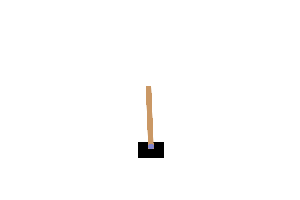

In [ ]:
#|hide
video_logger = SimpleVSCodeVideoPlayer()
pipe = GymDataPipe(['CartPole-v1'],None,n=100,seed=0,include_images=True)
pipe = VSCodePipeline(pipe)

list(pipe);
pipe.show()

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()

/usr/local/lib/python3.8/dist-packages/nbdev/export.py:54: UserWarning: Notebook '/home/fastrl_user/fastrl/nbs/07_Agents/02_Continuous/12u_agents.ppo.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
